# VASP TiO2 benchmark performance

This notebook compares the performance of the VASP TiO2 benchmark (pure DFT) between ARCHER and different configurations on ARCHER2.

Basic information:
- Uses `vasp_gam`
- `NELM = 10`

Performance summary:
- Best performance from VASP 6.3.0
- Best performance from 64 MPI processes per node - leaves 64 cores idle on each node
- Best performance with `NCORE = 64`
- Scales well to 16 nodes
- Using OpenMP threads results in worse performance

We compute performance using the time for the "LOOP+" cycle as reported by VASP.

Performance is plotted as LOOP+ per second (i.e. inverse of LOOP+ cycle time in seconds).

We have investigated the performance of different versions of VASP and different numerical libraries:

- On ARCHER: Intel Compilers 17, Cray FFTW, Intel MKL 17, Cray MPICH
- On ARCHER2: GCC compilers (v 10.x or 11.x), HPE Cray FFTW 3.3.8.x, HPE Cray MPICH, AOCL or HPE Cray LibSci

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [5]:
results = [
    'ARCHER','ARCHER2-4c_LibSci-20.10',
    'ARCHER2-4c_LibSci-21.03',
    'ARCHER2-4c_AOCL-3.0', 
    'ARCHER2_VASP544_LibSci-21.04_OFI',
    'ARCHER2_VASP630_AOCL-3.1_OFI',
    'ARCHER2_VASP544_LibSci-21.04_UCX',
    'ARCHER2_VASP630_AOCL-3.1_UCX'
          ]
systems = {
    'ARCHER': 'ARCHER',
    'ARCHER2-4c_LibSci-20.10': 'ARCHER2',
    'ARCHER2-4c_LibSci-21.03': 'ARCHER2',
    'ARCHER2-4c_MKL-19.5': 'ARCHER2',
    'ARCHER2-4c_MKL-21.2': 'ARCHER2',
    'ARCHER2-4c_AOCL-3.0': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_OFI': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_OFI': 'ARCHER2',
    'ARCHER2_VASP544_LibSci-21.04_UCX': 'ARCHER2',
    'ARCHER2_VASP630_AOCL-3.1_UCX': 'ARCHER2'
}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../TiO2/results/' + res
    filelist = filemanip.get_filelist(wdir, 'TiO2MCC_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max"))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER


/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
2     48        1       48    6     8    1     0.000112  0.000112  0.000112   
                              12    4    1     0.000117  0.000117  0.000117   
4     96        1       96    12    8    1     0.000228  0.000228  0.000228   
                              24    4    1     0.000227  0.000227  0.000227   
8     192       1       192   48    4    1     0.000431  0.000431  0.000431   
16    384       1       384   96    4    1     0.000768  0.000768  0.000768   
32    768       1       768   192   4    1     0.001651  0.001651  0.001651   

                                                             LOOP+             \
                                                   mean        min     median   
Nodes Processes Threads Cores NCORE NPAR KPAR  

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   8     16   1     0.000191  0.000191  0.000191   
                              16    8    1     0.000196  0.000196  0.000196   
                              32    4    1     0.000212  0.000212  0.000212   
2     128       1       128   32    4    1     0.000350  0.000350  0.000350   
      256       1       256   16    16   1     0.000374  0.000374  0.000374   
                              32    8    1     0.000401  0.000407  0.000413   
                              64    4    1     0.000448  0.000473  0.000475   
                              128   2    1     0.000487  0.000492  0.000494   
                              256   1    1     0.000365  0.000368  0.000369   
4     512       1       512   32    16   1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
8     512       1       512   64    8    1     0.000923  0.000923  0.000923   
                              128   4    1     0.000961  0.000961  0.000961   
      1024      1       1024  64    16   1     0.001240  0.001240  0.001240   
                              128   8    1     0.001222  0.001222  0.001222   
16    1024      1       1024  64    16   1     0.001796  0.001796  0.001796   
                              128   8    1     0.001856  0.001856  0.001856   
      2048      1       2048  64    32   1     0.001903  0.001903  0.001903   
32    2048      1       2048  64    32   1     0.002892  0.002892  0.002892   
                              128   16   1     0.001363  0.001363  0.001363   
      4096      1       4096  64    64   1     0.002

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     128       1       128   32    4    1     0.000135  0.000135  0.000135   
2     256       1       256   128   2    1     0.000288  0.000288  0.000288   
4     512       1       512   128   4    1     0.000555  0.000555  0.000555   
8     512       1       512   64    8    1     0.000568  0.000568  0.000568   
                              128   4    1     0.000568  0.000568  0.000568   
      1024      1       1024  64    16   1     0.001056  0.001056  0.001056   
                              128   8    1     0.001032  0.001037  0.001041   
16    1024      1       1024  64    16   1     0.001071  0.001071  0.001071   
                              128   8    1     0.001068  0.001068  0.001068   
      2048      1       2048  64    32   1     0.001

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    16    4    1     0.000229  0.000229  0.000229   
                              32    2    1     0.000262  0.000262  0.000262   
                              64    1    1     0.000291  0.000291  0.000291   
      128       1       128   16    8    1     0.000200  0.000200  0.000200   
                              32    4    1     0.000221  0.000221  0.000221   
                              64    2    1     0.000250  0.000250  0.000250   
2     128       1       128   32    4    1     0.000523  0.000523  0.000523   
                              64    2    1     0.000623  0.000623  0.000623   
                              128   1    1     0.000542  0.000542  0.000542   
      256       1       256   32    8    1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    16    4    1     0.000231  0.000231  0.000231   
                              32    2    1     0.000276  0.000276  0.000276   
                              64    1    1     0.000301  0.000301  0.000301   
      128       1       128   32    4    1     0.000229  0.000234  0.000234   
                              64    2    1     0.000278  0.000278  0.000278   
2     128       1       128   32    4    1     0.000540  0.000540  0.000540   
                              64    2    1     0.000633  0.000633  0.000633   
                              128   1    1     0.000546  0.000546  0.000546   
      256       1       256   64    4    1     0.000533  0.000533  0.000533   
                              128   2    1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


                                                   Perf                      \
                                                    min    median       max   
Nodes Processes Threads Cores NCORE NPAR KPAR                                 
1     64        1       64    16    4    1     0.000226  0.000226  0.000226   
                              32    2    1     0.000254  0.000255  0.000258   
                              64    1    1     0.000289  0.000290  0.000292   
      128       1       128   16    8    1     0.000198  0.000199  0.000199   
                              32    4    1     0.000210  0.000210  0.000211   
                              64    2    1     0.000250  0.000250  0.000251   
2     128       1       128   32    4    1     0.000484  0.000495  0.000500   
                              64    2    1     0.000595  0.000618  0.000621   
                              128   1    1     0.000543  0.000544  0.000544   
      256       1       256   32    8    1     0.000

/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)
/home/jovyan/work/others/VASP/analysis/../../../python-modules/appanalysis/vasp.py:144: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_num = df.drop(['File', 'Date'], 1)


## Performance Comparison

This plot compares performance for different systems/configurations with respect to "reserved" cores. Reserved cores is defined as the number of nodes multiplied by the total number of cores per node and represents the amount of resource reserved for the run rather than the number of cores used. This is used to be able to compare performance across different systems even when not all cores on a compute node are used.

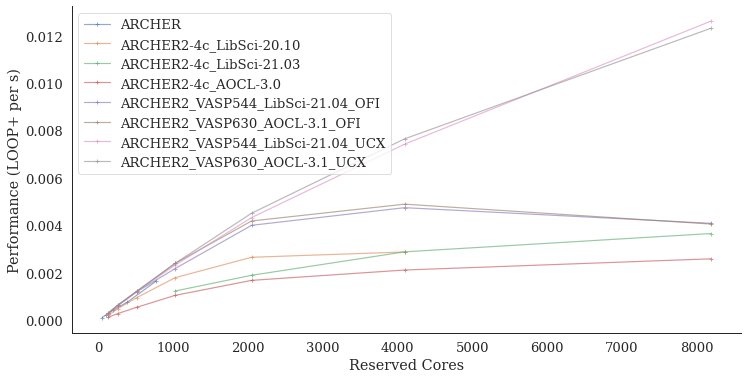

In [6]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (LOOP+ per s)')
plt.legend(loc='best')
sns.despine()